# SuperNeuroABM Tutorial: Building Heterogeneous Spiking Neural Networks

This tutorial demonstrates how to use SuperNeuroABM to create and simulate spiking neural networks with different neuron types including Leaky Integrate-and-Fire (LIF) and Izhikevich neurons, and implementation of both external and internal synapses.

## About SuperNeuroABM and SAGESim

SuperNeuroABM is a spiking neural network simulation framework built on top of **SAGESim** (Scalable Agent-based GPU Enabled Simulation). SAGESim provides the underlying agent-based modeling infrastructure. SuperNeuroABM leverages SAGESim's capabilities to create specialized neuromorphic computing environments where:
- **Neurons** are implemented as agents with internal state and step functions
- **Synapses** are connections between neurons agents with their own dynamics, and they themselves are also implemented as agents
- **Networks** emerge from the interactions between these agents
- **Simulations** run efficiently on modern parallel hardware

## Table of Contents
1. [Introduction to SuperNeuroABM](#Introduction-to-SuperNeuroABM)
2. [LIF Neuron Model](#LIF-Neuron-Model)
3. [Izhikevich Neuron Model](#Izhikevich-Neuron-Model)
4. [Synapse Models](#Synapse-Models)
5. [Heterogeneous Network: LIF and Izhikevich](#Heterogeneous-Network:-LIF-and-Izhikevich)
6. [Running Simulations](#Running-Simulations)
7. [Analyzing Results](#Analyzing-Results)



## 1. Introduction to SuperNeuroABM

SuperNeuroABM is a framework for building and simulating spiking neural networks using agent-based modeling. It provides:
- Various neuron models (LIF, Izhikevich)
- Synaptic (Current-based synapse with parametrizable exponential profile)
- GPU acceleration support

The framework is built on top of SAGESim and supports both CPU and GPU execution.

In [2]:
# Install SAGESim
! pip install sagesim==0.4.0.dev1
# Install SuperNeuroABM
! pip install superneuroabm==1.0.0.dev1

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from superneuroabm.model import NeuromorphicModel

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 2. LIF Neuron Model

The Leaky Integrate-and-Fire (LIF) neuron is a simplified model of biological neurons. It integrates incoming currents and fires a spike when the membrane potential crosses a threshold.

### LIF Neuron Equation
The membrane potential $V$ evolves according to:

$$C \frac{dV}{dt} = \frac{V_{rest} - V}{R} + I_{synapse} + I_{bias} + I_{input}$$

Where:
- $C$: Membrane capacitance (F)
- $R$: Membrane resistance (Ω)
- $V_{rest}$: Resting potential (mV)
- $I_{synapse}$: Synaptic input current (A)
- $I_{bias}$: Bias current (A)
- $I_{input}$: Direct input current (A)

When $V \geq V_{threshold}$, the neuron fires a spike and $V$ is reset to $V_{reset}$.


## 3. Izhikevich Neuron Model

The Izhikevich neuron model provides more biological realism while maintaining computational efficiency. It can reproduce various neuronal firing patterns observed in real neurons.

### Izhikevich Neuron Equations
The model consists of two differential equations:

$$\frac{dv}{dt} = k(v - v_{rest})(v - v_{thr}) - u + I$$

$$\frac{du}{dt} = a(b(v - v_{rest}) - u)$$

When $v \geq v_{peak}$:
- $v \leftarrow v_{reset}$
- $u \leftarrow u + d$

Where:
- $v$: Membrane potential (mV)
- $u$: Recovery variable
- $k$: Membrane capacitance scaling factor
- $a$: Recovery time constant
- $b$: Recovery variable sensitivity
- $d$: After-spike reset of recovery variable
- $v_{peak}$: Peak voltage (mV)
- $v_{thr}$: Threshold voltage (mV)
- $v_{rest}$: Resting potential (mV)
- $v_{reset}$: Reset potential (mV)


### Key Differences Between Neuron Types:

- **LIF Neuron**: Simple, computationally efficient, uniform spike responses
- **Izhikevich Neuron**: More biologically realistic, complex spike patterns, adaptation mechanisms

In [3]:
# Define LIF neuron parameters as global variables
C_lif = 10e-9          # Membrane capacitance (10 nF)
R_lif = 1e6            # Membrane resistance (1 MΩ) - Updated from test
vthr_lif = -45         # Spike threshold voltage (mV)
tref_lif = 5e-3        # Refractory period (5 ms)
vrest_lif = -60        # Resting potential (mV)
vreset_lif = -70       # Reset potential after spike (mV)
tref_allows_integration_lif = 1  # Allow integration during refractory period
I_in_lif = 0           # Direct input current (A)

# LIF parameters as a list for model creation
lif_params = [C_lif, R_lif, vthr_lif, tref_lif, vrest_lif, vreset_lif, tref_allows_integration_lif, I_in_lif]

# Define Izhikevich neuron parameters as global variables
k_izh = 1.2           # Membrane capacitance scaling factor
vthr_izh = -45        # Threshold voltage (mV)
C_izh = 150           # Membrane capacitance (pF)
a_izh = 0.01          # Recovery time constant
b_izh = 5             # Recovery variable sensitivity
vpeak_izh = 50        # Peak voltage (mV)
vrest_izh = -75       # Resting potential (mV)
d_izh = 130           # After-spike reset of recovery variable
vreset_izh = -56      # Reset potential (mV)
I_in_izh = 500        # Direct input current (pA) 

# Izhikevich parameters as a list for model creation
izh_params = [k_izh, vthr_izh, C_izh, a_izh, b_izh, vpeak_izh, vrest_izh, d_izh, vreset_izh, I_in_izh]

# Display parameter values
lif_param_names = ['C (F)', 'R (Ω)', 'V_thr (mV)', 't_ref (s)', 'V_rest (mV)', 'V_reset (mV)', 'Ref_integration', 'I_in (A)']
izh_param_names = ['k', 'V_thr (mV)', 'C (pF)', 'a', 'b', 'V_peak (mV)', 'V_rest (mV)', 'd', 'V_reset (mV)', 'I_in (pA)']

print("LIF Neuron Parameters:")
print("=" * 40)
for name, value in zip(lif_param_names, lif_params):
    print(f"{name:15}: {value}")

print("\nIzhikevich Neuron Parameters:")
print("=" * 40)
for name, value in zip(izh_param_names, izh_params):
    print(f"{name:15}: {value}")

LIF Neuron Parameters:
C (F)          : 1e-08
R (Ω)          : 1000000.0
V_thr (mV)     : -45
t_ref (s)      : 0.005
V_rest (mV)    : -60
V_reset (mV)   : -70
Ref_integration: 1
I_in (A)       : 0

Izhikevich Neuron Parameters:
k              : 1.2
V_thr (mV)     : -45
C (pF)         : 150
a              : 0.01
b              : 5
V_peak (mV)    : 50
V_rest (mV)    : -75
d              : 130
V_reset (mV)   : -56
I_in (pA)      : 500


## 4. Synapse Models

Synapses connect neurons and transmit signals between them. SuperNeuroABM supports exponential synapses with the following dynamics:

### Exponential Synapse
The synaptic current follows:

$$I_{synapse}(t) = weight \cdot scale \cdot \exp\left(-\frac{t}{\tau_{fall}}\right)$$

Where:
- $weight$: Synaptic strength
- $scale$: Scaling factor
- $\tau_{fall}$: Decay time constant
- $delay$: Synaptic transmission delay

### Synapse Parameters

In SuperNeuroABM, synapses are implemented as agents in the SAGESim framework, allowing them to:
- **Maintain their own internal state** (synaptic current, plasticity variables)
- **Process incoming spikes** with specified delays
- **Apply synaptic dynamics** (exponential decay, rise times)
- **Implement plasticity rules** (STDP, homeostasis)

The synapse step functions are executed in parallel with neuron step functions, enabling efficient large-scale simulations.

In [4]:
# Define synapse parameters as global variables

# Strong synapse parameters
weight_strong = 2.0    # Synaptic weight (strength)
delay_strong = 1.0     # Transmission delay (ms)
scale_strong = 1.0     # Scaling factor
tau_fall_strong = 1e-2 # Decay time constant (s) - Updated from test
tau_rise_strong = 0    # Rise time constant (instantaneous)

# Weak synapse parameters
weight_weak = 1.0      # Synaptic weight (strength)
delay_weak = 1.0       # Transmission delay (ms)
scale_weak = 1.0       # Scaling factor
tau_fall_weak = 1e-2   # Decay time constant (s) - Updated from test
tau_rise_weak = 0      # Rise time constant (instantaneous)

# Internal synapse parameters
weight_internal = 1.0  # Synaptic weight (strength)
delay_internal = 1.0   # Transmission delay (ms)
scale_internal = 1.0   # Scaling factor
tau_fall_internal = 1e-2 # Decay time constant (s) - Updated from test
tau_rise_internal = 0    # Rise time constant (instantaneous)

# Create synapse parameter lists for different synapse types
strong_synapse = [weight_strong, delay_strong, scale_strong, tau_fall_strong, tau_rise_strong]
weak_synapse = [weight_weak, delay_weak, scale_weak, tau_fall_weak, tau_rise_weak]
internal_synapse = [weight_internal, delay_internal, scale_internal, tau_fall_internal, tau_rise_internal]

print("Synapse Parameters:")
print("=" * 40)
print(f"Strong synapse: {strong_synapse}")
print(f"Weak synapse:   {weak_synapse}")
print(f"Internal synapse: {internal_synapse}")

print("\nSynapse Parameter Explanation:")
print("- Weight: Controls synaptic strength (higher = stronger connection)")
print("- Delay: Synaptic transmission delay in milliseconds")
print("- Scale: Scaling factor applied to synaptic current")
print("- Tau_fall: Exponential decay time constant (10 ms)")
print("- Tau_rise: Rise time constant (0 = instantaneous)")

Synapse Parameters:
Strong synapse: [2.0, 1.0, 1.0, 0.01, 0]
Weak synapse:   [1.0, 1.0, 1.0, 0.01, 0]
Internal synapse: [1.0, 1.0, 1.0, 0.01, 0]

Synapse Parameter Explanation:
- Weight: Controls synaptic strength (higher = stronger connection)
- Delay: Synaptic transmission delay in milliseconds
- Scale: Scaling factor applied to synaptic current
- Tau_fall: Exponential decay time constant (10 ms)
- Tau_rise: Rise time constant (0 = instantaneous)


## 5. Heterogeneous Network: LIF and Izhikevich

Now let's create the heterogeneous network from the updated test case: dual external synapses feeding into a LIF neuron, which then connects to an Izhikevich neuron.

### Network Architecture
```
External Input A ──→ Synapse A ──┐
                                 ├──→ LIF Soma ──→ Synapse C ──→ Izhikevich Soma
External Input B ──→ Synapse B ──┘
```

### SAGESim Agent Architecture

In this network, SAGESim manages:
- **5 agents total**: 2 soma agents + 3 synapse agents
- **Parallel execution**: All agents update simultaneously each time step
- **Message passing**: Spikes are transmitted between agents via SAGESim's communication system
- **State management**: Each agent maintains its own internal state variables
- **Step functions**: Custom neural dynamics implemented as agent step functions

In [5]:
# Create model instance
model = NeuromorphicModel()

# Set global simulation parameters (updated from test)
model.register_global_property("dt", 1e-3)  # Time step (1 ms)
model.register_global_property("I_bias", 0)  # No bias current

# Use LIF neuron parameters from global variables
lif_soma_parameters = lif_params

# Set initial internal state for LIF neuron
v_lif = -60  # Initial membrane voltage (resting potential)
tcount = 0   # Time counter
tlast = 0    # Last spike time
I_synapse = 0  # Initial synaptic current
lif_internal_state = [v_lif, tcount, tlast, I_synapse]

# Create LIF neuron
lif_soma = model.create_soma(
    breed="LIF_Soma",
    parameters=lif_soma_parameters,
    default_internal_state=lif_internal_state,
)

# Use Izhikevich neuron parameters from global variables
izh_soma_parameters = izh_params

# Set initial internal state for Izhikevich neuron
v_izh = -75  # Initial membrane voltage (resting potential)
u_izh = 0    # Initial recovery variable
izh_internal_state = [v_izh, u_izh]

# Create Izhikevich neuron
izh_soma = model.create_soma(
    breed="IZH_Soma",
    parameters=izh_soma_parameters,
    default_internal_state=izh_internal_state,
)

# Use synaptic parameters from global variables
# Synapse A: stronger weight
synapse_parameters_A = strong_synapse
# Synapse B: weaker weight
synapse_parameters_B = weak_synapse
# Synapse C: internal connection
synapse_parameters_C = internal_synapse

# Initial synaptic current
synapse_internal_state = [0.0]

# Create external input synapse A (stronger input to LIF)
syn_ext_A = model.create_synapse(
    breed="Single_Exp_Synapse",
    pre_soma_id=np.nan,  # External input
    post_soma_id=lif_soma,
    parameters=synapse_parameters_A,
    default_internal_state=synapse_internal_state,
)

# Create external input synapse B (weaker input to LIF)
syn_ext_B = model.create_synapse(
    breed="Single_Exp_Synapse",
    pre_soma_id=np.nan,  # External input
    post_soma_id=lif_soma,
    parameters=synapse_parameters_B,
    default_internal_state=synapse_internal_state,
)

# Create internal synapse C (LIF -> Izhikevich)
syn_int_C = model.create_synapse(
    breed="Single_Exp_Synapse",
    pre_soma_id=lif_soma,
    post_soma_id=izh_soma,
    parameters=synapse_parameters_C,
    default_internal_state=synapse_internal_state,
)



print(f"Created heterogeneous network:")
print(f"  LIF Soma ID: {lif_soma}")
print(f"  Izhikevich Soma ID: {izh_soma}")
print(f"  External Synapse A ID: {syn_ext_A}")
print(f"  External Synapse B ID: {syn_ext_B}")
print(f"  Internal Synapse C ID: {syn_int_C}")

print(f"\nNetwork topology:")
print(f"  External Input A → Synapse A → LIF Soma")
print(f"  External Input B → Synapse B → LIF Soma")
print(f"  LIF Soma → Synapse C → Izhikevich Soma")

Created heterogeneous network:
  LIF Soma ID: 0
  Izhikevich Soma ID: 1
  External Synapse A ID: 2
  External Synapse B ID: 3
  Internal Synapse C ID: 4

Network topology:
  External Input A → Synapse A → LIF Soma
  External Input B → Synapse B → LIF Soma
  LIF Soma → Synapse C → Izhikevich Soma


## 6. Running Simulations

Now let's run a simulation with carefully designed input patterns to demonstrate the heterogeneous network behavior. We'll use the same parameters as in the test case.

In [6]:

# Initialize the simulation environment
model.setup(use_gpu=True)  # Use CPU for this tutorial

# Define input spike patterns (from test case)
# Synapse A receives early, strong spikes
spikes_A = [(2, 1), (10, 1), (20, 1)]  # (time_tick, spike_value)

# Synapse B receives delayed, weaker spikes that can overlap with A
spikes_B = [(5, 1), (12, 1), (25, 1)]  # (time_tick, spike_value)

print("Input spike patterns:")
print(f"  Synapse A (strong): {spikes_A}")
print(f"  Synapse B (weak):   {spikes_B}")

# Inject spikes into external synapses
for spike in spikes_A:
    model.add_spike(synapse_id=syn_ext_A, tick=spike[0], value=spike[1])

for spike in spikes_B:
    model.add_spike(synapse_id=syn_ext_B, tick=spike[0], value=spike[1])

# Run simulation (parameters from test case)
simulation_ticks = 600  # Run for 600 time steps
model.simulate(ticks=simulation_ticks)

# Traceability -- Extract simulation results
results = {
    'lif_soma_states': np.array(model.get_internal_states_history(agent_id=lif_soma)),
    'izh_soma_states': np.array(model.get_internal_states_history(agent_id=izh_soma)),
    'synapse_A_states': np.array(model.get_internal_states_history(agent_id=syn_ext_A)),
    'synapse_B_states': np.array(model.get_internal_states_history(agent_id=syn_ext_B)),
    'synapse_C_states': np.array(model.get_internal_states_history(agent_id=syn_int_C)),
    'lif_soma_spikes': model.get_spike_times(soma_id=lif_soma),
    'izh_soma_spikes': model.get_spike_times(soma_id=izh_soma),
    'simulation_ticks': simulation_ticks,
    'spikes_A': spikes_A,
    'spikes_B': spikes_B
}


print("\nSimulation completed!")
print(f"LIF Soma spike times: {results['lif_soma_spikes']}")
print(f"Izhikevich Soma spike times: {results['izh_soma_spikes']}")
print(f"Total simulation ticks: {results['simulation_ticks']}")

print(f"\nNetwork Response Summary:")
print(f"  Total input spikes: {len(results['spikes_A']) + len(results['spikes_B'])}")
print(f"  LIF soma output spikes: {len(results['lif_soma_spikes'])}")
print(f"  Izhikevich soma output spikes: {len(results['izh_soma_spikes'])}")

Input spike patterns:
  Synapse A (strong): [(2, 1), (10, 1), (20, 1)]
  Synapse B (weak):   [(5, 1), (12, 1), (25, 1)]

Simulation completed!
LIF Soma spike times: [10, 17, 24]
Izhikevich Soma spike times: [15, 25, 81, 175, 261, 347, 433, 519]
Total simulation ticks: 600

Network Response Summary:
  Total input spikes: 6
  LIF soma output spikes: 3
  Izhikevich soma output spikes: 8


## 7. Analyzing Results

Let's create comprehensive visualizations to understand the network dynamics.

Creating visualization with default time window (50 time steps)...


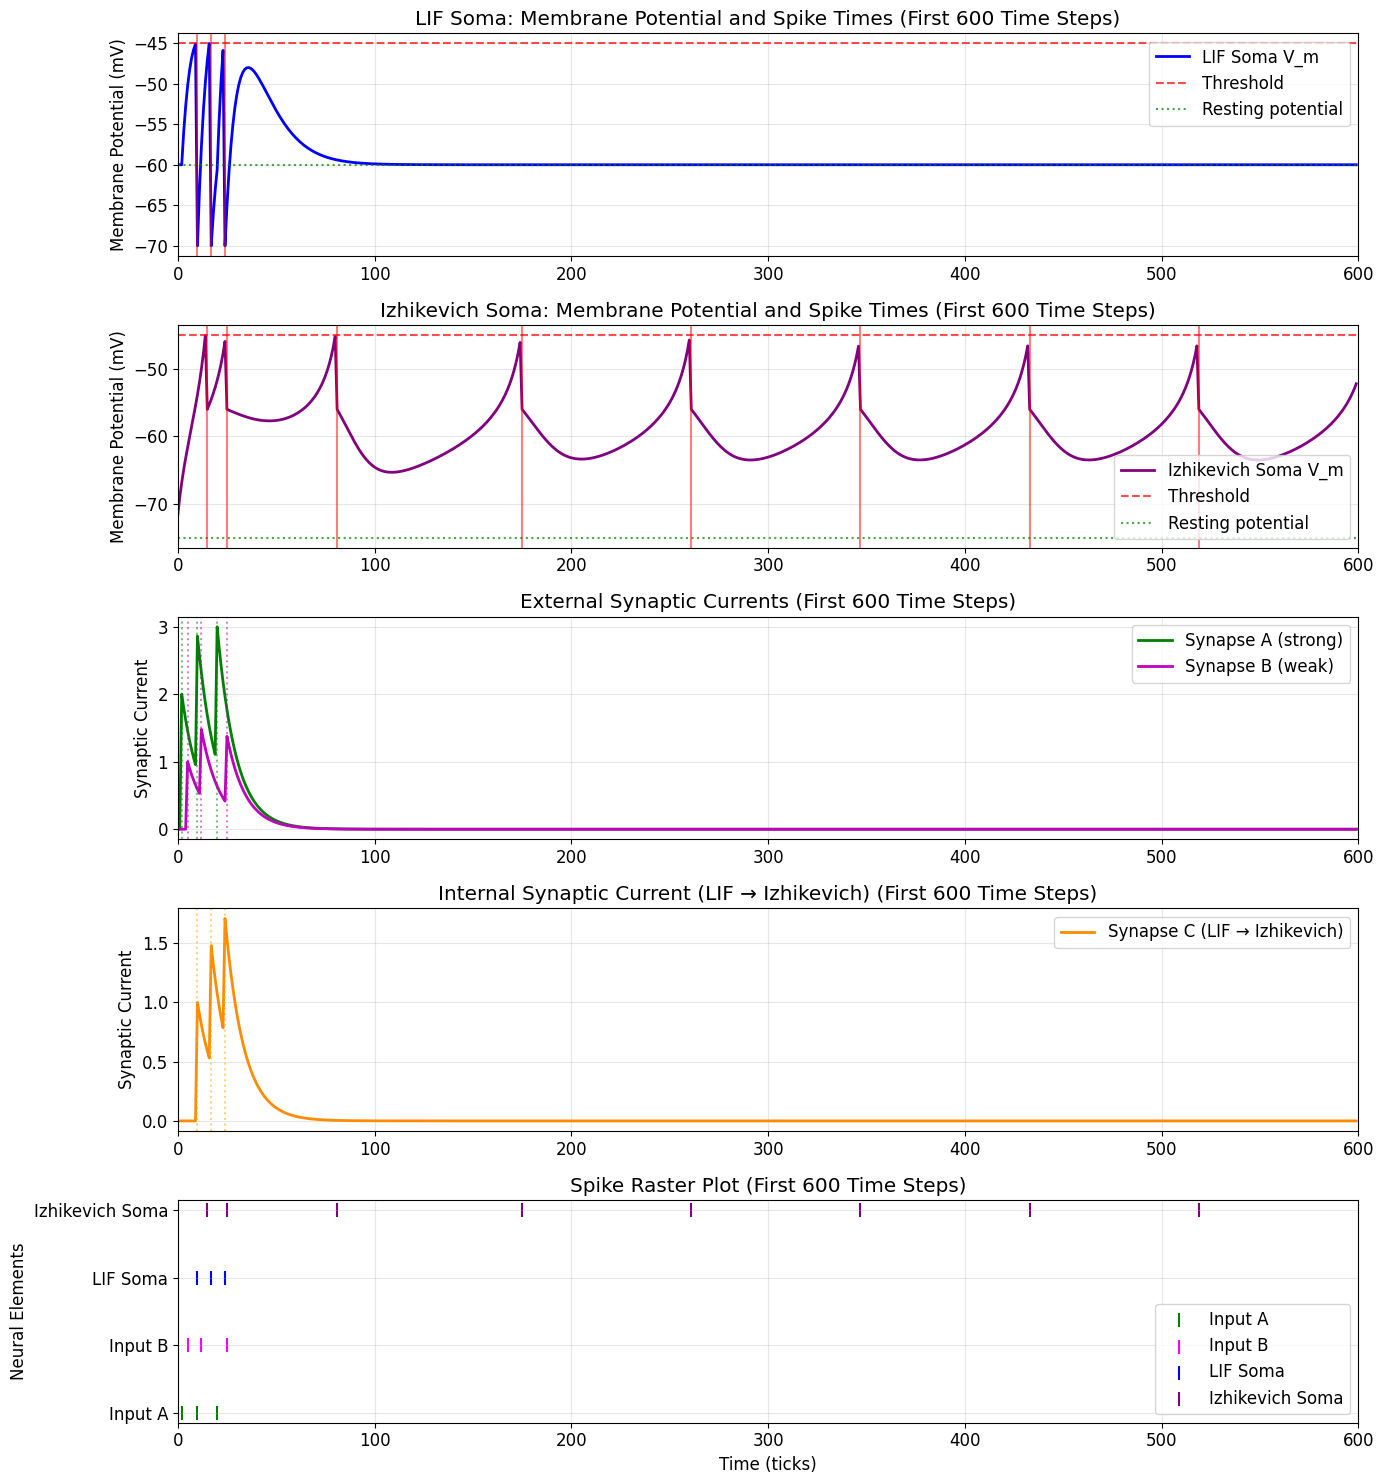

In [7]:
def create_heterogeneous_visualization(results, time_window=50):
    """
    Create comprehensive visualization of the heterogeneous network simulation results.
    
    Args:
        results: Dictionary containing simulation results
        time_window: Number of time steps to display (default: 50)
    """
    # Create figure with subplots (reduced from 6 to 5 - removed recovery variable plot)
    fig, axes = plt.subplots(5, 1, figsize=(14, 15))
    
    # Time vector
    time_ticks = np.arange(results['simulation_ticks'])
    
    # Plot 1: LIF Soma membrane potential
    ax1 = axes[0]
    ax1.plot(time_ticks, results['lif_soma_states'][:, 0], 'b-', linewidth=2, label='LIF Soma V_m')
    ax1.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax1.axhline(y=-60, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['lif_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax1.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.set_title(f'LIF Soma: Membrane Potential and Spike Times (First {time_window} Time Steps)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, time_window)
    
    # Plot 2: Izhikevich Soma membrane potential
    ax2 = axes[1]
    ax2.plot(time_ticks, results['izh_soma_states'][:, 0], 'purple', linewidth=2, label='Izhikevich Soma V_m')
    ax2.axhline(y=-45, color='r', linestyle='--', alpha=0.7, label='Threshold')
    ax2.axhline(y=-75, color='g', linestyle=':', alpha=0.7, label='Resting potential')
    
    # Mark spike times
    for spike_time in results['izh_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax2.axvline(x=spike_time, color='r', alpha=0.5, linestyle='-')
    
    ax2.set_ylabel('Membrane Potential (mV)')
    ax2.set_title(f'Izhikevich Soma: Membrane Potential and Spike Times (First {time_window} Time Steps)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, time_window)
    
    # Plot 3: External synaptic currents A and B (was Plot 4, now Plot 3)
    ax3 = axes[2]
    ax3.plot(time_ticks, results['synapse_A_states'][:, 0], 'g-', linewidth=2, label='Synapse A (strong)')
    ax3.plot(time_ticks, results['synapse_B_states'][:, 0], 'm-', linewidth=2, label='Synapse B (weak)')
    
    # Mark input spike times
    for spike_time, _ in results['spikes_A']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax3.axvline(x=spike_time, color='g', alpha=0.5, linestyle=':')
    for spike_time, _ in results['spikes_B']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax3.axvline(x=spike_time, color='m', alpha=0.5, linestyle=':')
    
    ax3.set_ylabel('Synaptic Current')
    ax3.set_title(f'External Synaptic Currents (First {time_window} Time Steps)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, time_window)
    
    # Plot 4: Internal synaptic current C (was Plot 5, now Plot 4)
    ax4 = axes[3]
    ax4.plot(time_ticks, results['synapse_C_states'][:, 0], 'darkorange', linewidth=2, label='Synapse C (LIF → Izhikevich)')
    
    # Mark LIF spike times (which drive synapse C)
    for spike_time in results['lif_soma_spikes']:
        if spike_time <= time_window:  # Only show spikes within time window
            ax4.axvline(x=spike_time, color='orange', alpha=0.5, linestyle=':')
    
    ax4.set_ylabel('Synaptic Current')
    ax4.set_title(f'Internal Synaptic Current (LIF → Izhikevich) (First {time_window} Time Steps)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, time_window)
    
    # Plot 5: Raster plot of all spikes (was Plot 6, now Plot 5)
    ax5 = axes[4]
    
    # Input spikes
    input_A_times = [spike[0] for spike in results['spikes_A']]
    input_B_times = [spike[0] for spike in results['spikes_B']]
    
    ax5.scatter(input_A_times, [0] * len(input_A_times), c='green', s=100, marker='|', label='Input A')
    ax5.scatter(input_B_times, [0.5] * len(input_B_times), c='magenta', s=100, marker='|', label='Input B')
    
    # Output spikes (limit to time window for visibility)
    lif_spikes_early = [s for s in results['lif_soma_spikes'] if s <= time_window]
    izh_spikes_early = [s for s in results['izh_soma_spikes'] if s <= time_window]
    
    ax5.scatter(lif_spikes_early, [1] * len(lif_spikes_early), c='blue', s=100, marker='|', label='LIF Soma')
    ax5.scatter(izh_spikes_early, [1.5] * len(izh_spikes_early), c='purple', s=100, marker='|', label='Izhikevich Soma')
    
    ax5.set_xlabel('Time (ticks)')
    ax5.set_ylabel('Neural Elements')
    ax5.set_title(f'Spike Raster Plot (First {time_window} Time Steps)')
    ax5.set_yticks([0, 0.5, 1, 1.5])
    ax5.set_yticklabels(['Input A', 'Input B', 'LIF Soma', 'Izhikevich Soma'])
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim(0, time_window)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create comprehensive visualization with default time window
print("Creating visualization with default time window (50 time steps)...")
fig = create_heterogeneous_visualization(results, time_window=600)

# # Example of how to use different time windows
# print(f"\nYou can easily change the time window by calling:")
# print(f"fig = create_heterogeneous_visualization(results, time_window=100)  # Show first 100 time steps")
# print(f"fig = create_heterogeneous_visualization(results, time_window=25)   # Show first 25 time steps")
# print(f"fig = create_heterogeneous_visualization(results, time_window=200)  # Show first 200 time steps")